In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
PATH = !pwd
PATH = PATH[-1]

In [3]:
PATH

'/home/ranuga/University/Esoft/ADM/MovieDataScraper/moviedata'

In [4]:
# cast_data = pd.read_json(f"{PATH}/data/CastScraper/CastScraper.json").sample(frac=1)

In [5]:
faq_data = pd.read_json(f"{PATH}/data/FAQScraper/FAQScraper.json").sample(frac=1)

In [6]:
movie_data = pd.read_json(f"{PATH}/data/MovieDetailsScraper/MovieDetailsScraper.json").sample(frac=1)

In [7]:
movie_basic_data = pd.read_json(f"{PATH}/data/MoviesBasicDetailsScraper/MoviesBasicDetailsScraper.json").sample(frac=1)

In [8]:
photo_data = pd.read_json(f"{PATH}/data/PhotoScraper/PhotoScraper.json").sample(frac=1)

In [9]:
technical_specification_data = pd.read_json(f"{PATH}/data/TechnicalSpecificationsScraper/TechnicalSpecificationsScraper.json").sample(frac=1)

In [10]:
video_data = pd.read_json(f"{PATH}/data/VideoScraper/VideoScraper.json").sample(frac=1)

In [11]:
movieIds = np.unique(movie_basic_data['movieID'].astype(str))

In [13]:
def type_faq_counter():
    faq_stats = {
        "movieID":[],
        "noOfFAQs":[]
    }
    for movieId in tqdm(movieIds):
        faqs_in_movie = faq_data[faq_data['movieID']==movieId]
        faq_stats["movieID"].append(movieId)
        faq_stats['noOfFAQs'].append(len(faqs_in_movie))
        for faq in faqs_in_movie["faqTitle"]:
            if not faq:
                continue
            name = faq.split(" ")[0].lower() + "Counter"
            if name not in faq_stats:
                faq_stats[name] = [0] * len(movieIds)
            faq_stats[name][np.where(movieIds == movieId)[0][0]] += 1
    return pd.DataFrame(faq_stats)

In [14]:
def prices():
    price_stats = {
        "movieID":[],
        "movieEarn":[],
        "movieBudget":[],
        "movieOther":[]
    }
    for movieId in tqdm(movieIds):
        earn = [0,1]
        budget = [0,1]
        other = [0,1]
        faqs_in_movie = faq_data[faq_data['movieID']==movieId]
        for content, title in zip(faqs_in_movie['faqContent'],faqs_in_movie['faqTitle']):
            if content and "$" in content:
                content = content.split(" ")
                if len(content) <= 1:
                    continue
                figure = content[-1][0].lower()
                price = float(content[0].replace(",","").replace("$", "")) * 1000 if figure == 'b' else float(content[0].replace(",","").replace("$", ""))
                if "earn" in title:
                    earn[0] += price
                    earn[1] += 1
                elif "budget" in title:
                    budget[0] += price
                    budget[1] += 1
                else:
                    other[0] += price
                    other[1] += 1
        price_stats["movieID"].append(movieId)
        price_stats["movieEarn"].append(earn[0]/earn[1])
        price_stats['movieBudget'].append(budget[0]/budget[1])
        price_stats['movieOther'].append(other[0]/other[1])
    return pd.DataFrame(price_stats)

In [15]:
def movie_statistics():
    movie_stats = movie_basic_data[["movieID","movieYear", "movieTime", "movieAvgRating", "movieRatingCount"]]
    movie_times = movie_stats['movieTime']
    movie_times_in_mins = []
    for movie_time in tqdm(movie_times):
        if not movie_time:
            movie_times_in_mins.append(None)
            continue
        split = movie_time.split(' ')
        if len(split) == 1:
            split.append("0m")
        hrs, mins = split
        tot = int(mins.strip().replace('m', ''))
        tot += int(hrs.strip().replace('h', '')) * 60 if hrs.strip().replace('h', '').isnumeric() else 0
        movie_times_in_mins.append(tot)
    movie_stats['movieTime'] = movie_times_in_mins
    ratings = movie_stats['movieRatingCount']
    new_ratings = []
    for rating in ratings:
        if not rating:
            new_ratings.append(None)
            continue
        sign = rating[-1].lower()
        if sign.isnumeric():
            new_ratings.append(float(rating))
        rating = rating.replace(rating[-1], "").strip()
        if sign == "k":
            new_ratings.append(float(rating) * 1000)
        elif sign == "m":
            new_ratings.append(float(rating) * 1000000)
    movie_stats['movieRatingCount'] = new_ratings
    return movie_stats

In [78]:
visualization_df = pd.merge(technical_specification_data[['movieID', 'specKey', 'specValue']], pd.merge(movie_statistics(), pd.merge(prices(),type_faq_counter(), on='movieID'), on="movieID"), on="movieID")

100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 816012.45it/s]
/tmp/ipykernel_388118/219438434.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_stats['movieTime'] = movie_times_in_mins
/tmp/ipykernel_388118/219438434.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_stats['movieRatingCount'] = new_ratings
100%|██████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 1647.41it/

In [79]:
visualization_df

,movieID,specKey,specValue,movieYear,movieTime,movieAvgRating,movieRatingCount,movieEarn,movieBudget,movieOther,...,howCounter,runtimeCounter,cameraCounter,negativeCounter,soundCounter,aspectCounter,printedCounter,colorCounter,cinematographicCounter,laboratoryCounter
0,T3BwZW5oZWltZXI=,None,None,2023,180.0,8.3,728000.0,429.666667,50.0,0.0,...,5,0,0,0,0,0,0,0,0,0
1,T3BwZW5oZWltZXI=,Cinematographic Process,IMAXPanavision Super 70Super 35(some shots),2023,180.0,8.3,728000.0,429.666667,50.0,0.0,...,5,0,0,0,0,0,0,0,0,0
2,T3BwZW5oZWltZXI=,Color,ColorBlack and White,2023,180.0,8.3,728000.0,429.666667,50.0,0.0,...,5,0,0,0,0,0,0,0,0,0
3,T3BwZW5oZWltZXI=,Sound mix,IMAX 6-TrackDolby DigitalDatasatDTS 70 mm,2023,180.0,8.3,728000.0,429.666667,50.0,0.0,...,5,0,0,0,0,0,0,0,0,0
4,T3BwZW5oZWltZXI=,Negative Format,35 mm(Kodak Vision3 500T 5219)65 mm(also horiz...,2023,180.0,8.3,728000.0,429.666667,50.0,0.0,...,5,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,VGhlIElkZWEgb2YgWW91,Camera,"Arri Alexa 35, Bausch and Lomb Super Baltar Le...",2024,115.0,6.1,401.0,0.000000,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
832,SHVtYW5l,Color,Color,2024,93.0,5.4,972.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
833,SHVtYW5l,None,None,2024,93.0,5.4,972.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
834,SHVtYW5l,Runtime,1h 33m(93 min),2024,93.0,5.4,972.0,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
# sns.pairplot(visualization_df)

/home/ranuga/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


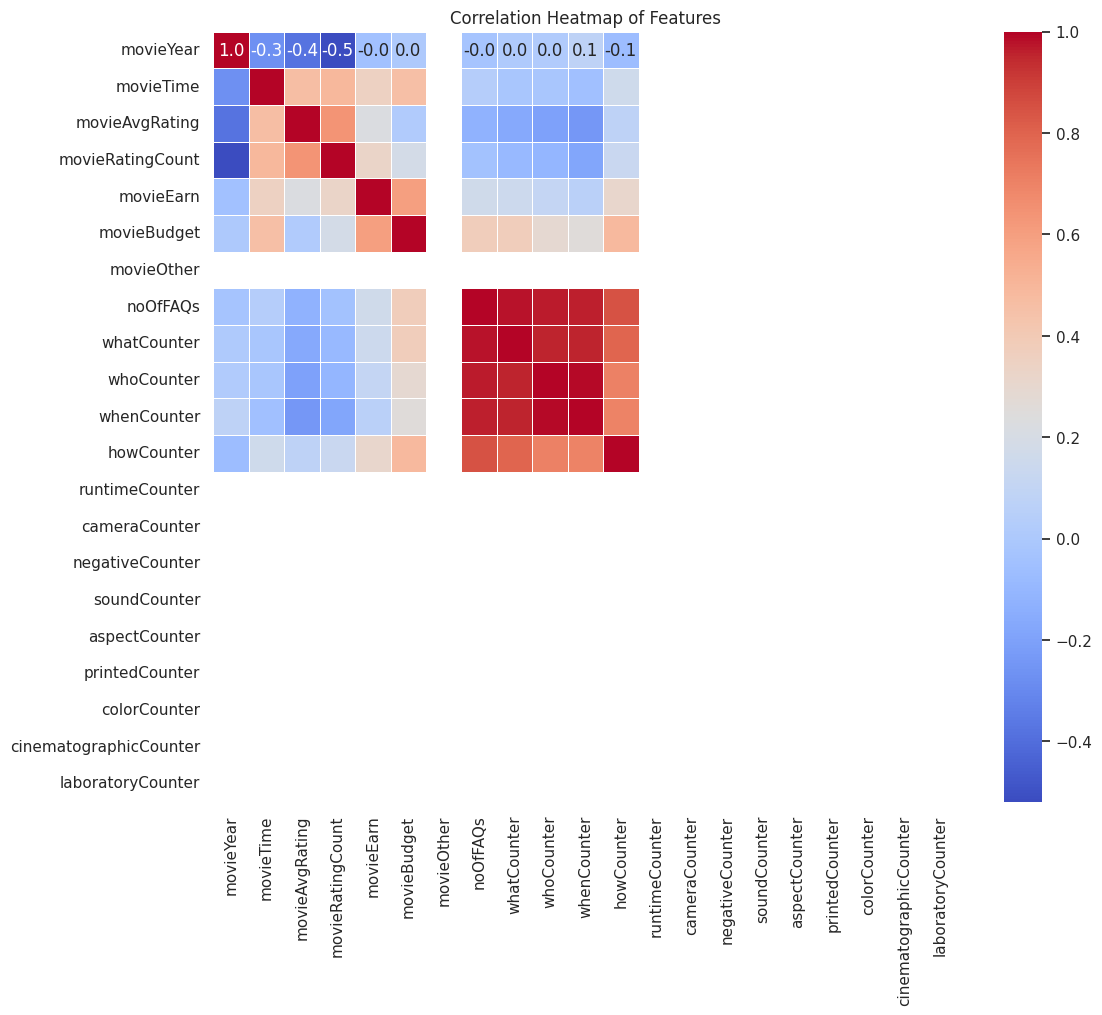

In [87]:
correlation_matrix = visualization_df.drop(['movieID', 'specKey', 'specValue'], axis=1).corr()
correlation_matrix.to_json("./data/heatmap.json")
# Set the style
sns.set(style="white")

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5)

# Set title and adjust layout
plt.title('Correlation Heatmap of Features')
# plt.tight_layout()

# Show plot
plt.savefig("./data/heatmap.png")
plt.show()

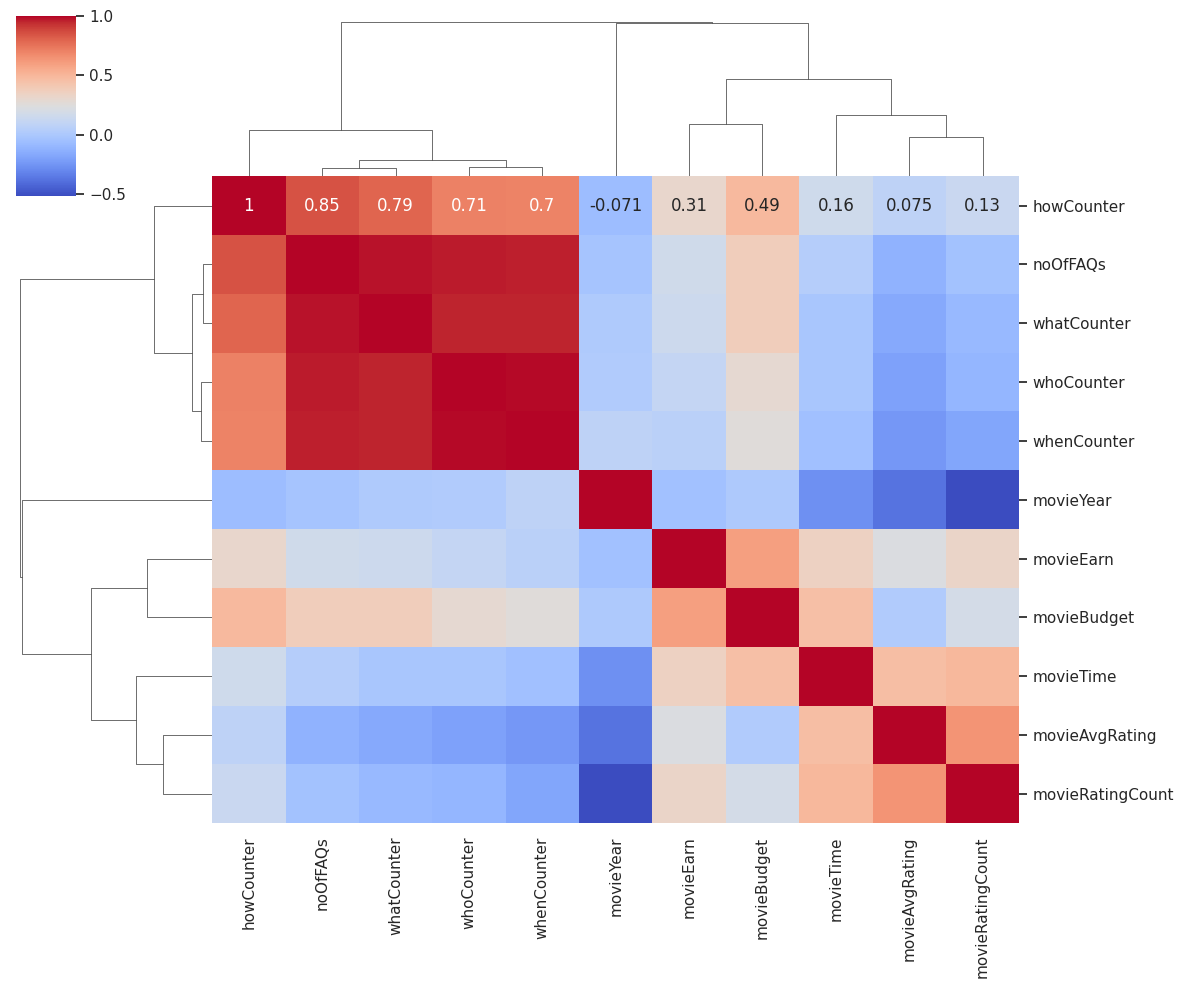

In [88]:
sns.clustermap(correlation_matrix.dropna(axis=1, how='all').dropna(axis=0, how='all'), 
               annot=True,  # Show the correlation values in each cell
               cmap='coolwarm',  # Color map
               figsize=(12, 10))  # Size of the figure

In [89]:
summary_stats.iloc[0]

movieYear           836.0
movieTime           836.0
movieAvgRating      836.0
movieRatingCount    836.0
movieEarn           836.0
movieBudget         836.0
Name: count, dtype: float64

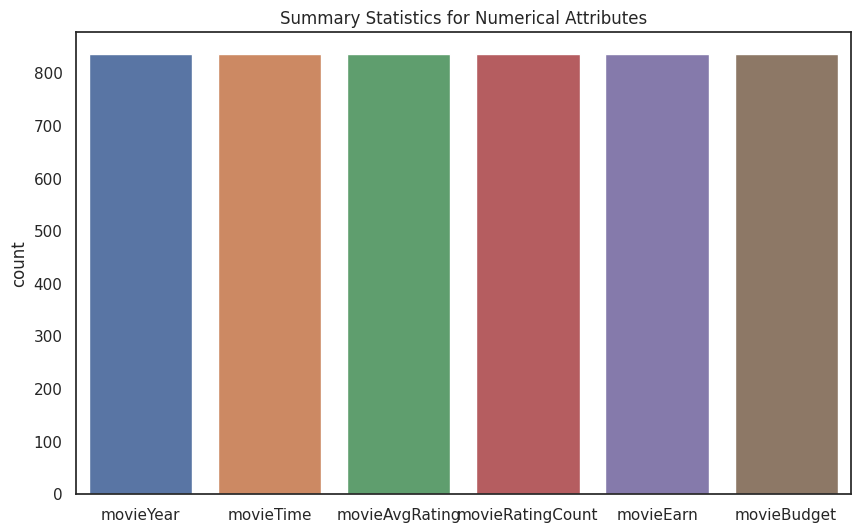

In [90]:
numerical_attributes = ['movieYear', 'movieTime', 'movieAvgRating', 'movieRatingCount', 'movieEarn', 'movieBudget']

# Generating summary statistics
summary_stats = visualization_df[numerical_attributes].describe()

# Adding median as an additional row
median_row = visualization_df[numerical_attributes].median().to_frame().T
median_row.index = ['50%']
summary_stats = pd.concat([summary_stats, median_row])

# Extract summary statistics from the DataFrame
summary_stats_values = summary_stats.iloc[0]
summary_stats_name = summary_stats.iloc[0].name

# Bar plot for summary statistics
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_stats.columns, y=summary_stats_values)
plt.title('Summary Statistics for Numerical Attributes')
plt.ylabel(summary_stats_name)
plt.show()

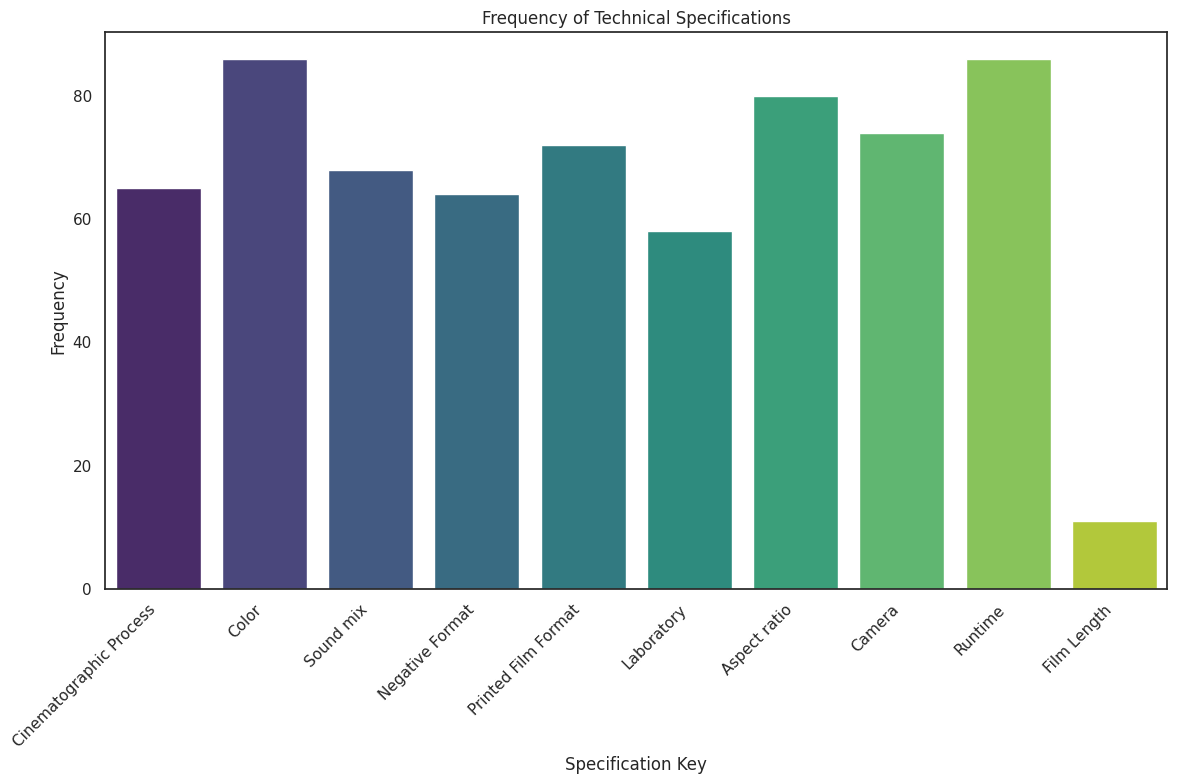

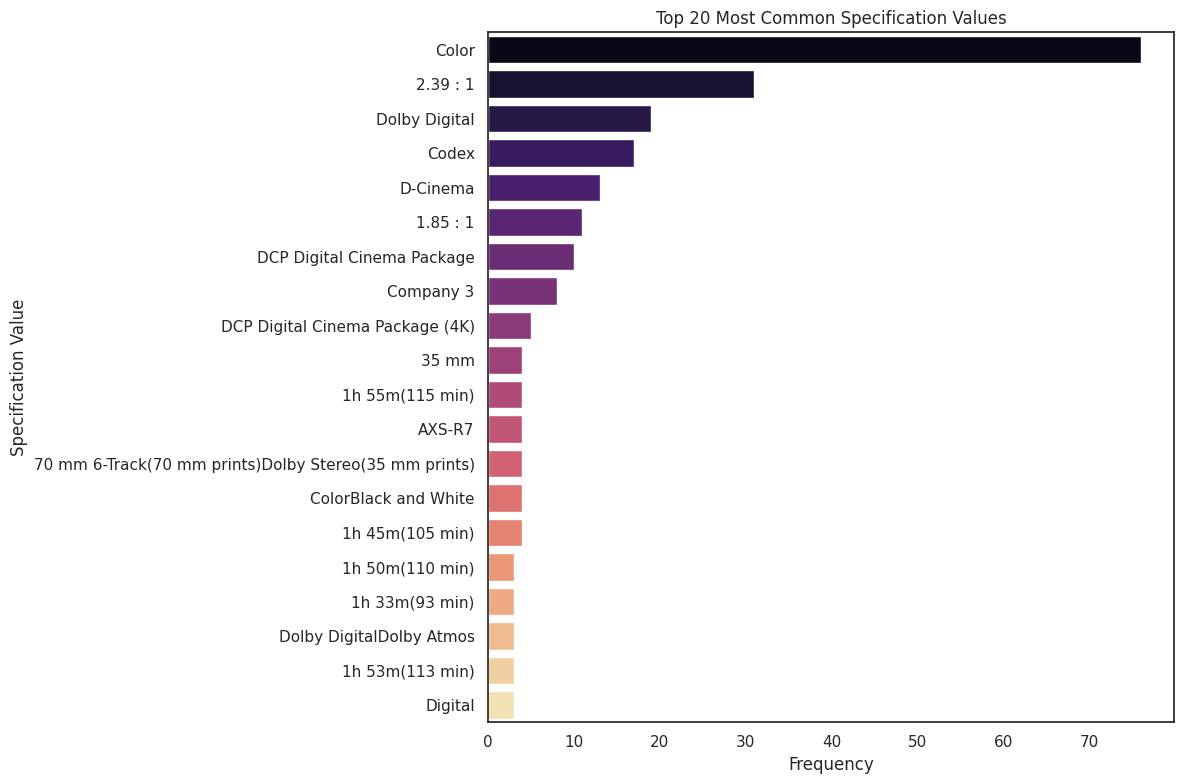

In [93]:
# Count plot for specKey
plt.figure(figsize=(12, 8))
sns.countplot(data=visualization_df, x='specKey', palette='viridis')
plt.title('Frequency of Technical Specifications')
plt.xlabel('Specification Key')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Count plot for specValue
plt.figure(figsize=(12, 8))
sns.countplot(data=visualization_df, y='specValue', palette='magma', order=visualization_df['specValue'].value_counts().index[:20])
plt.title('Top 20 Most Common Specification Values')
plt.xlabel('Frequency')
plt.ylabel('Specification Value')
plt.tight_layout()
plt.show()

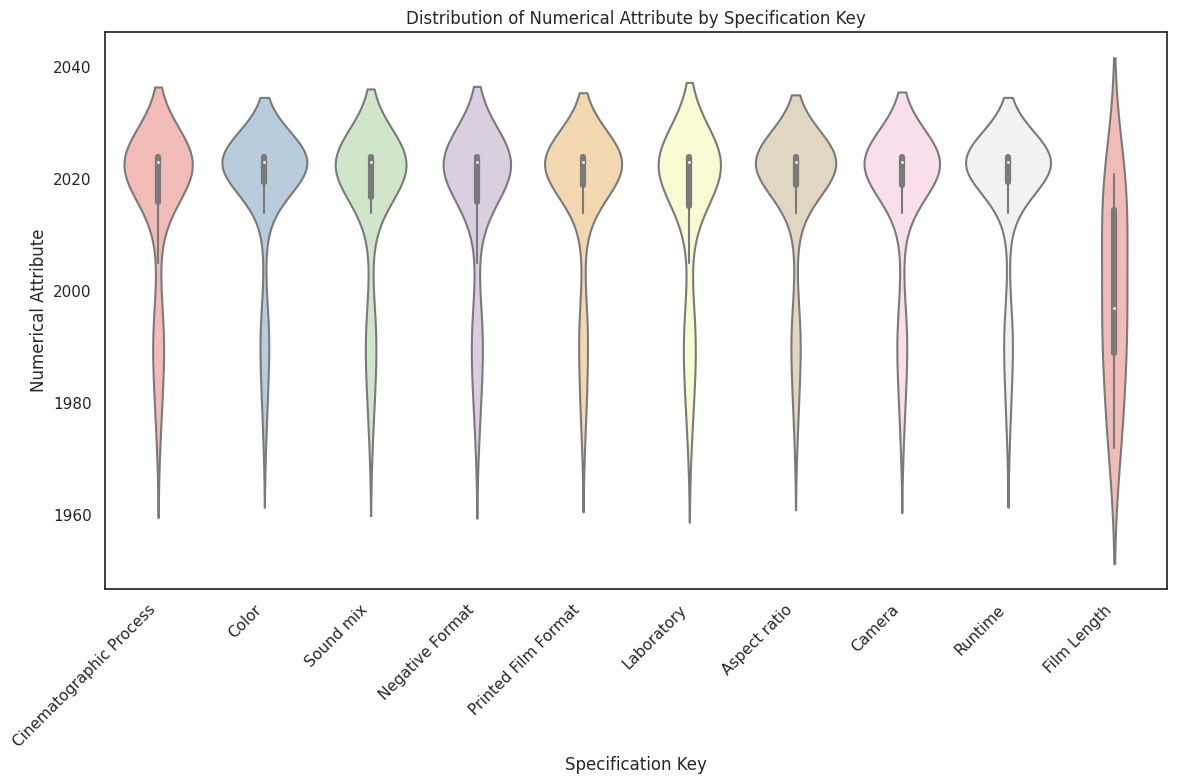

In [99]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=visualization_df, x='specKey', y='movieYear', palette='Pastel1')
plt.title('Distribution of Numerical Attribute by Specification Key')
plt.xlabel('Specification Key')
plt.ylabel('Numerical Attribute')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

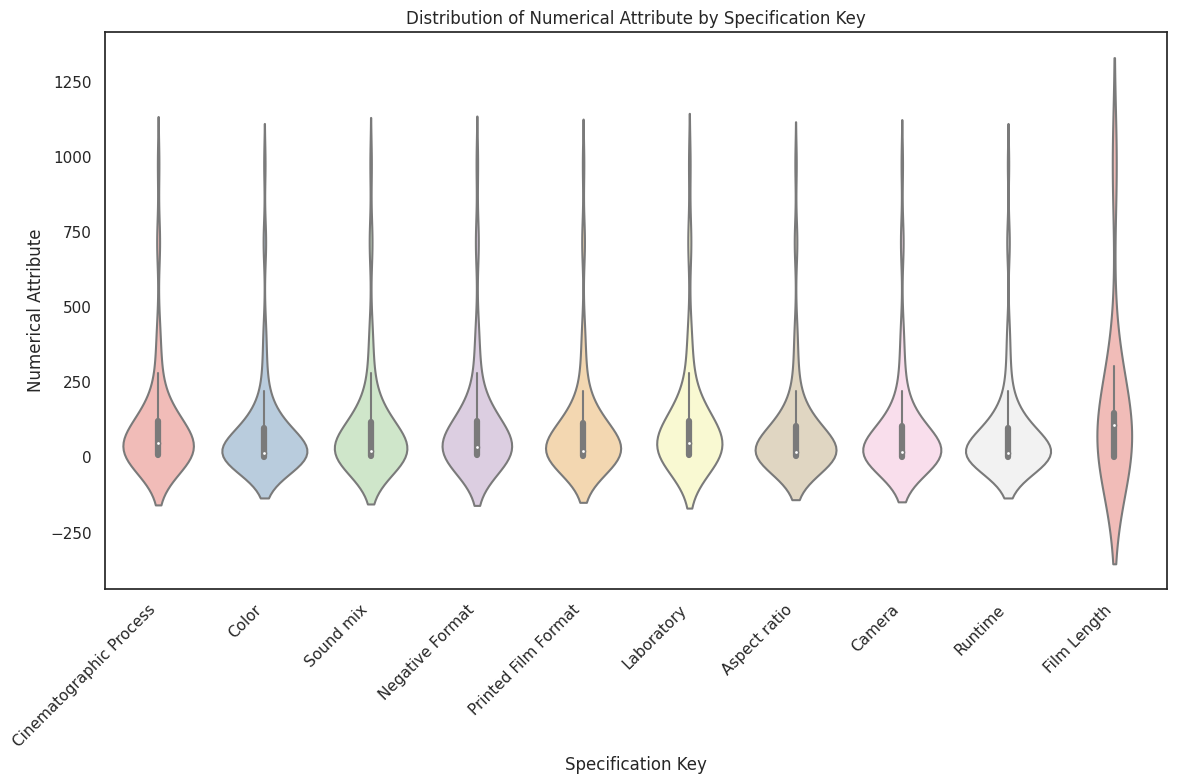

In [101]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=visualization_df, x='specKey', y='movieEarn', palette='Pastel1')
plt.title('Distribution of Numerical Attribute by Specification Key')
plt.xlabel('Specification Key')
plt.ylabel('Numerical Attribute')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

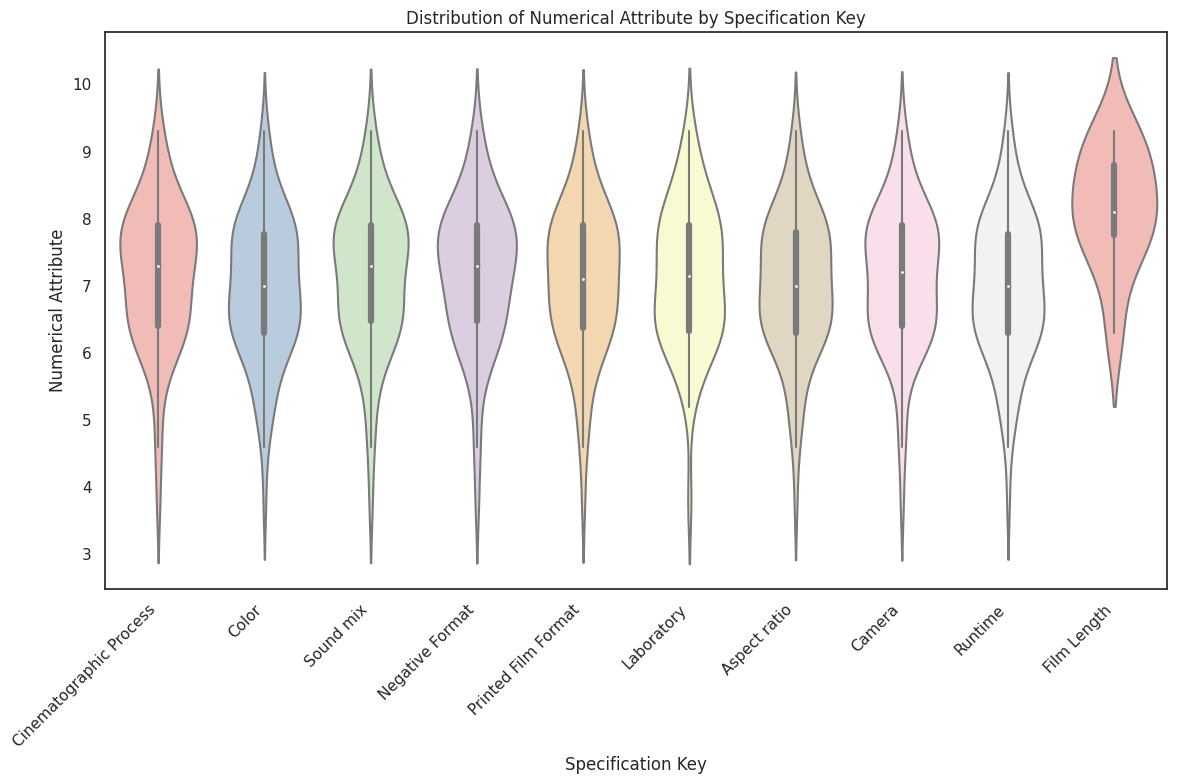

In [102]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=visualization_df, x='specKey', y='movieAvgRating', palette='Pastel1')
plt.title('Distribution of Numerical Attribute by Specification Key')
plt.xlabel('Specification Key')
plt.ylabel('Numerical Attribute')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

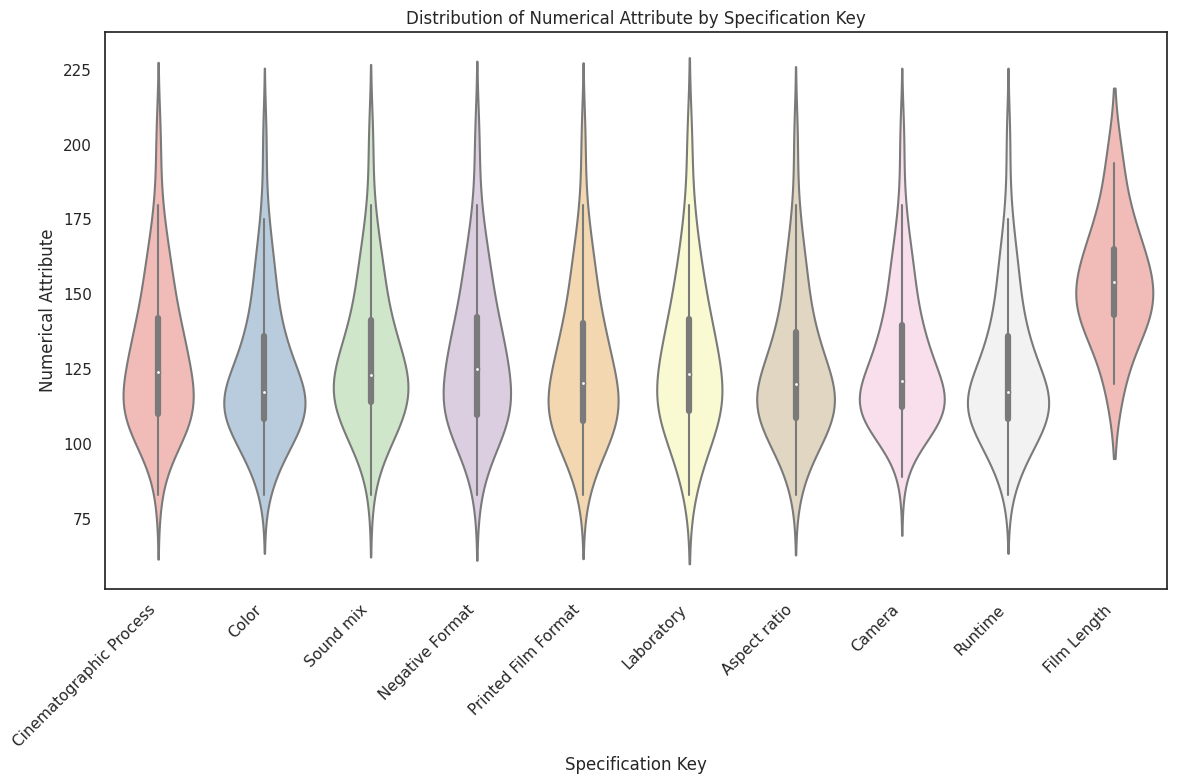

In [103]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=visualization_df, x='specKey', y='movieTime', palette='Pastel1')
plt.title('Distribution of Numerical Attribute by Specification Key')
plt.xlabel('Specification Key')
plt.ylabel('Numerical Attribute')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [108]:
descriptions = movie_data['movieDescription']
story_lines = movie_data['storyLine']

In [111]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

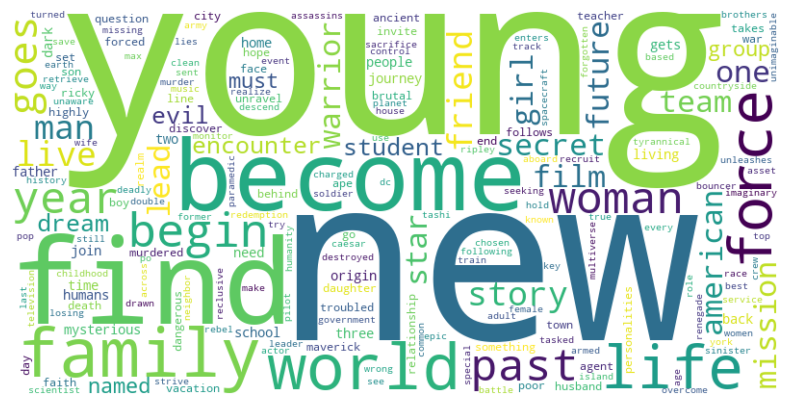

In [116]:
# Tokenize and preprocess the text data
stop_words = set(stopwords.words('english'))

word_tokens = []
for description in descriptions:
    words = word_tokenize(description.lower())  # Convert to lowercase
    words = [word for word in words if word.isalnum()]  # Remove punctuation
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    word_tokens.extend(words)

# Join the words into a single string
text = ' '.join(word_tokens)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

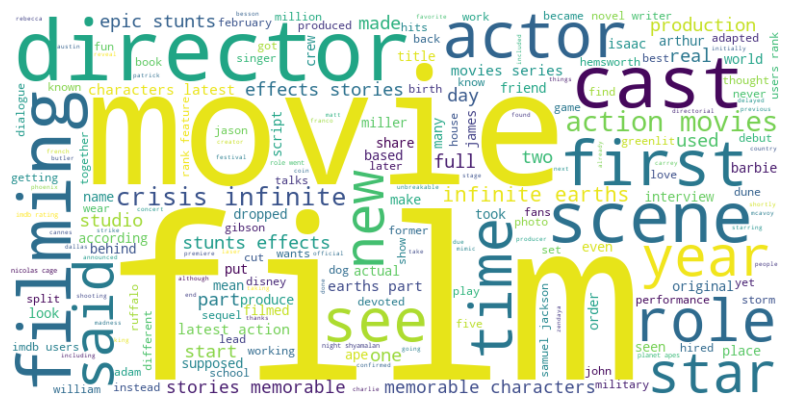

In [119]:
# Tokenize and preprocess the text data
stop_words = set(stopwords.words('english'))

word_tokens = []
for story_line in story_lines.dropna():
    words = word_tokenize(story_line.lower())  # Convert to lowercase
    words = [word for word in words if word.isalnum()]  # Remove punctuation
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    word_tokens.extend(words)

# Join the words into a single string
text = ' '.join(word_tokens)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

/home/ranuga/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ranuga/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ranuga/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ranuga/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

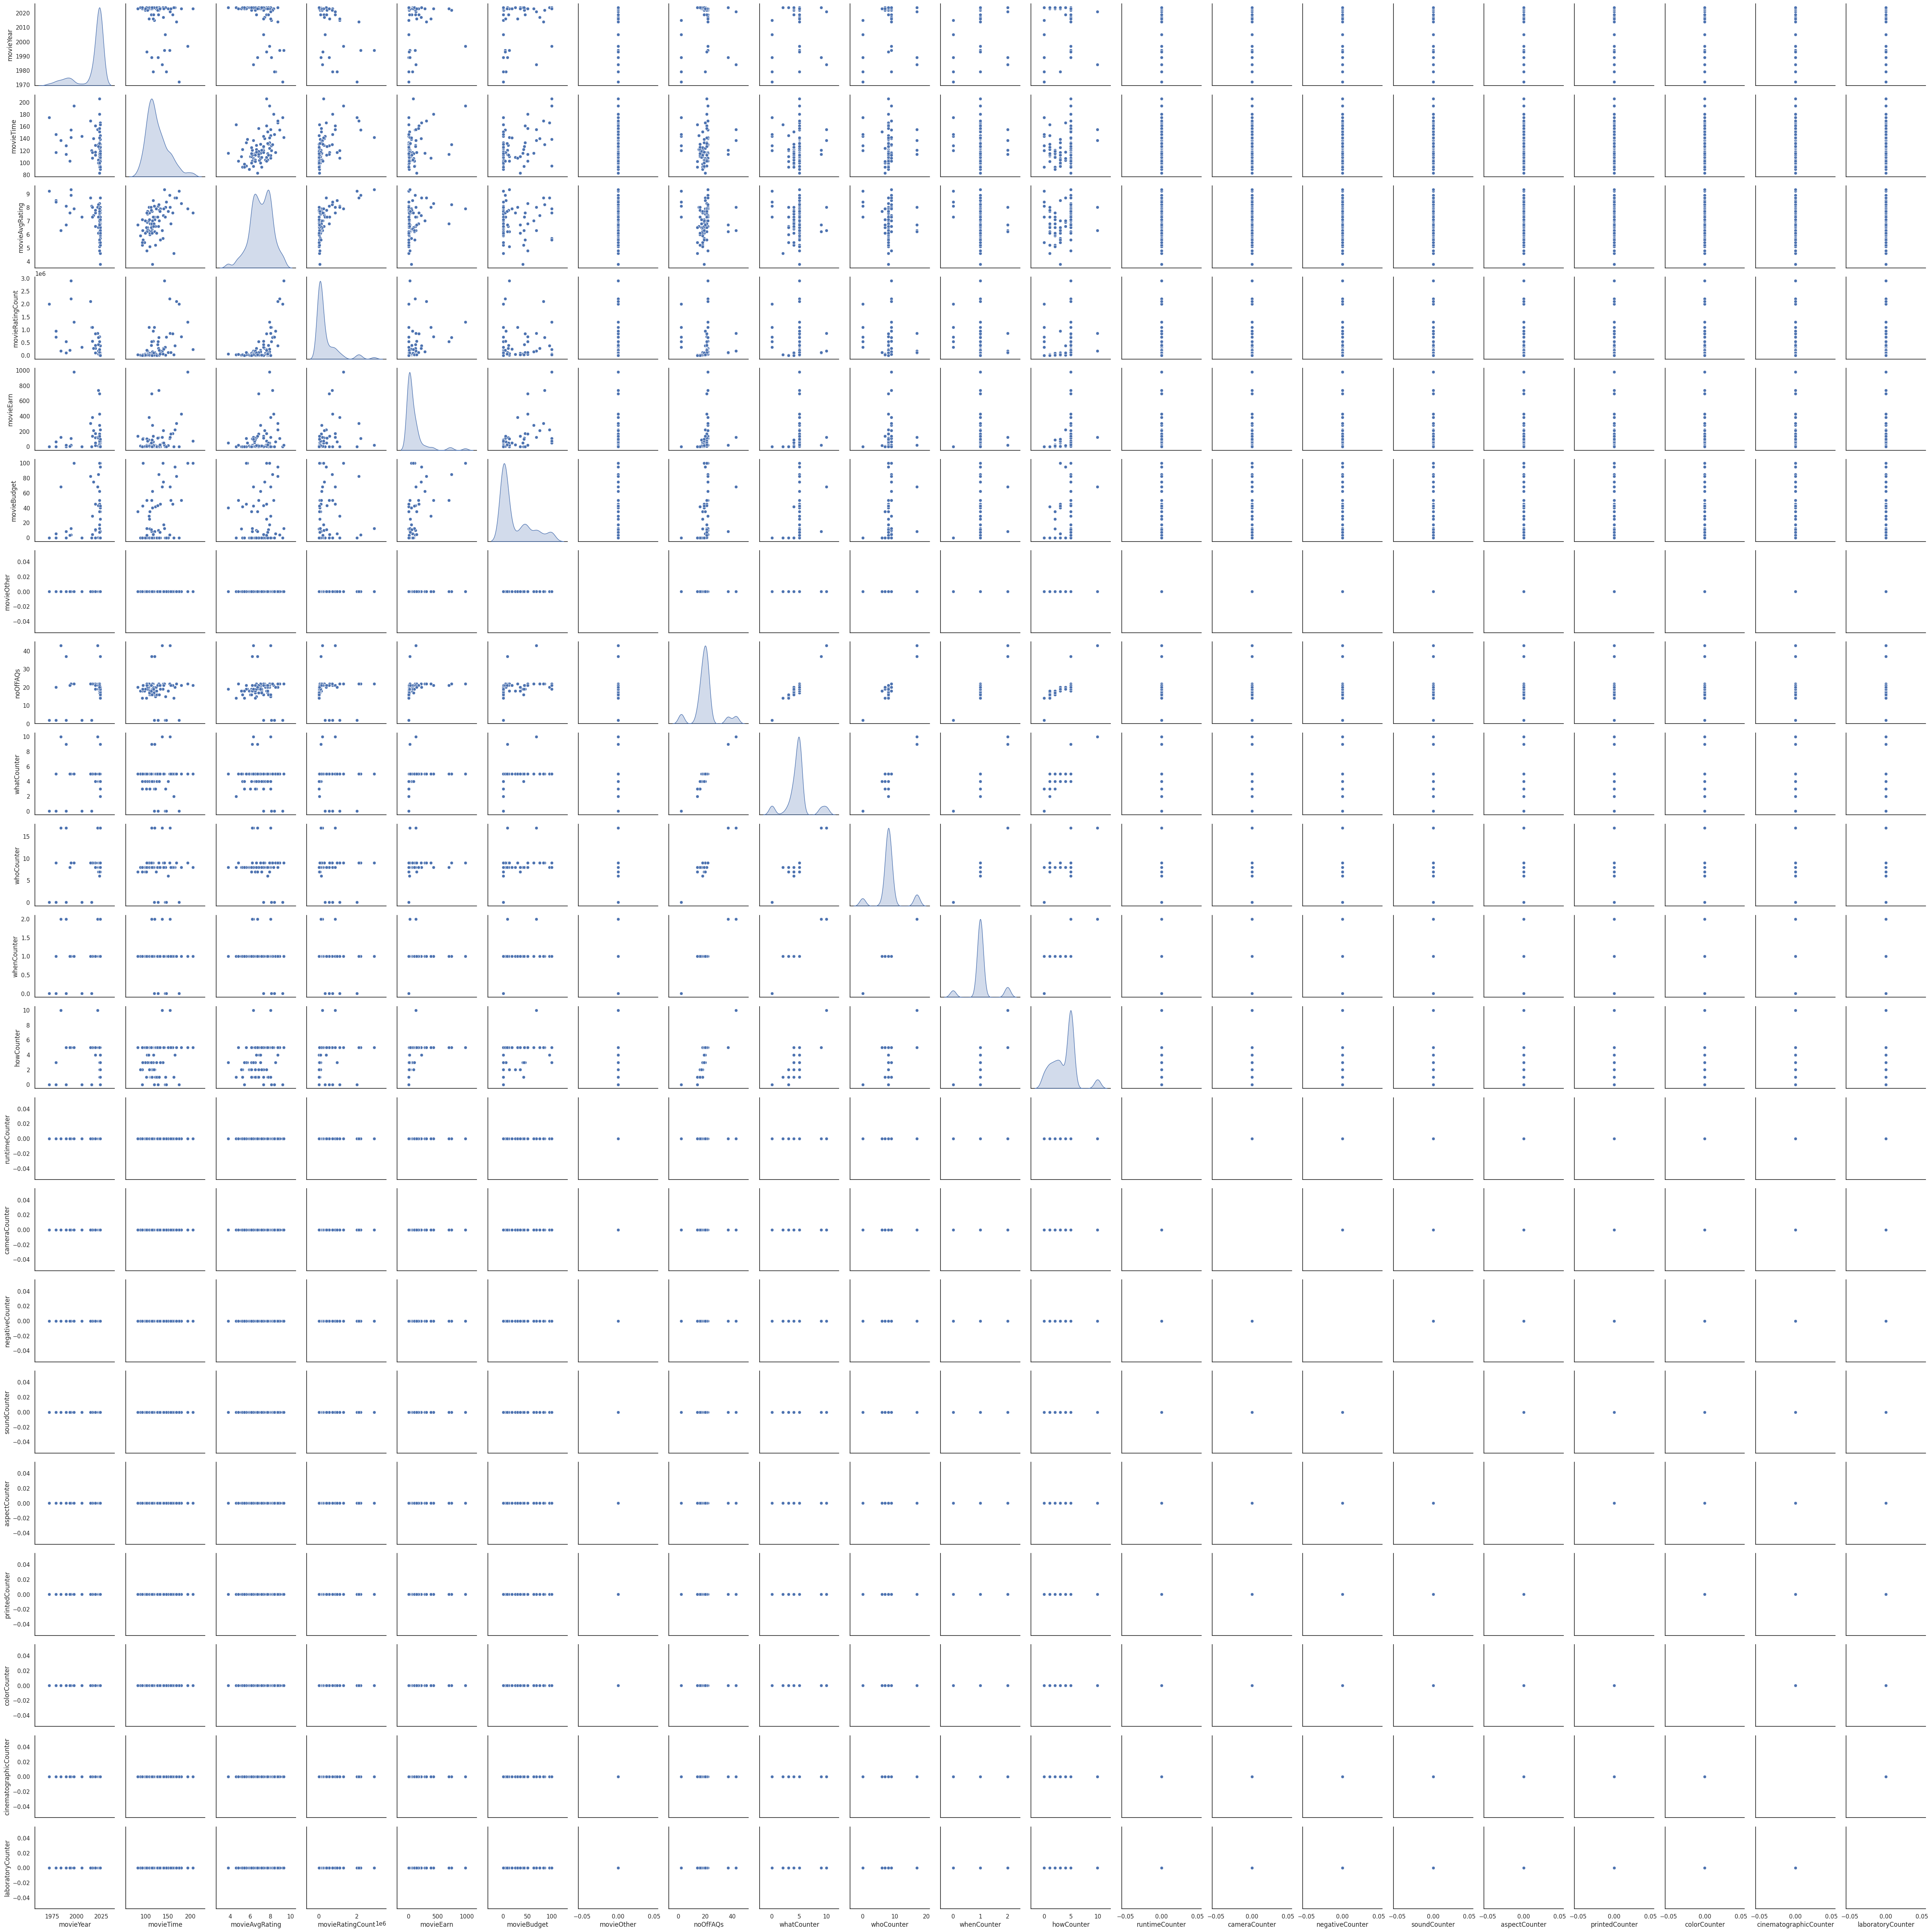

In [123]:
sns.pairplot(visualization_df, diag_kind="kde")

/tmp/ipykernel_388118/3489459079.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_df.dropna(inplace=True)
/home/ranuga/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ranuga/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ranuga/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be remo

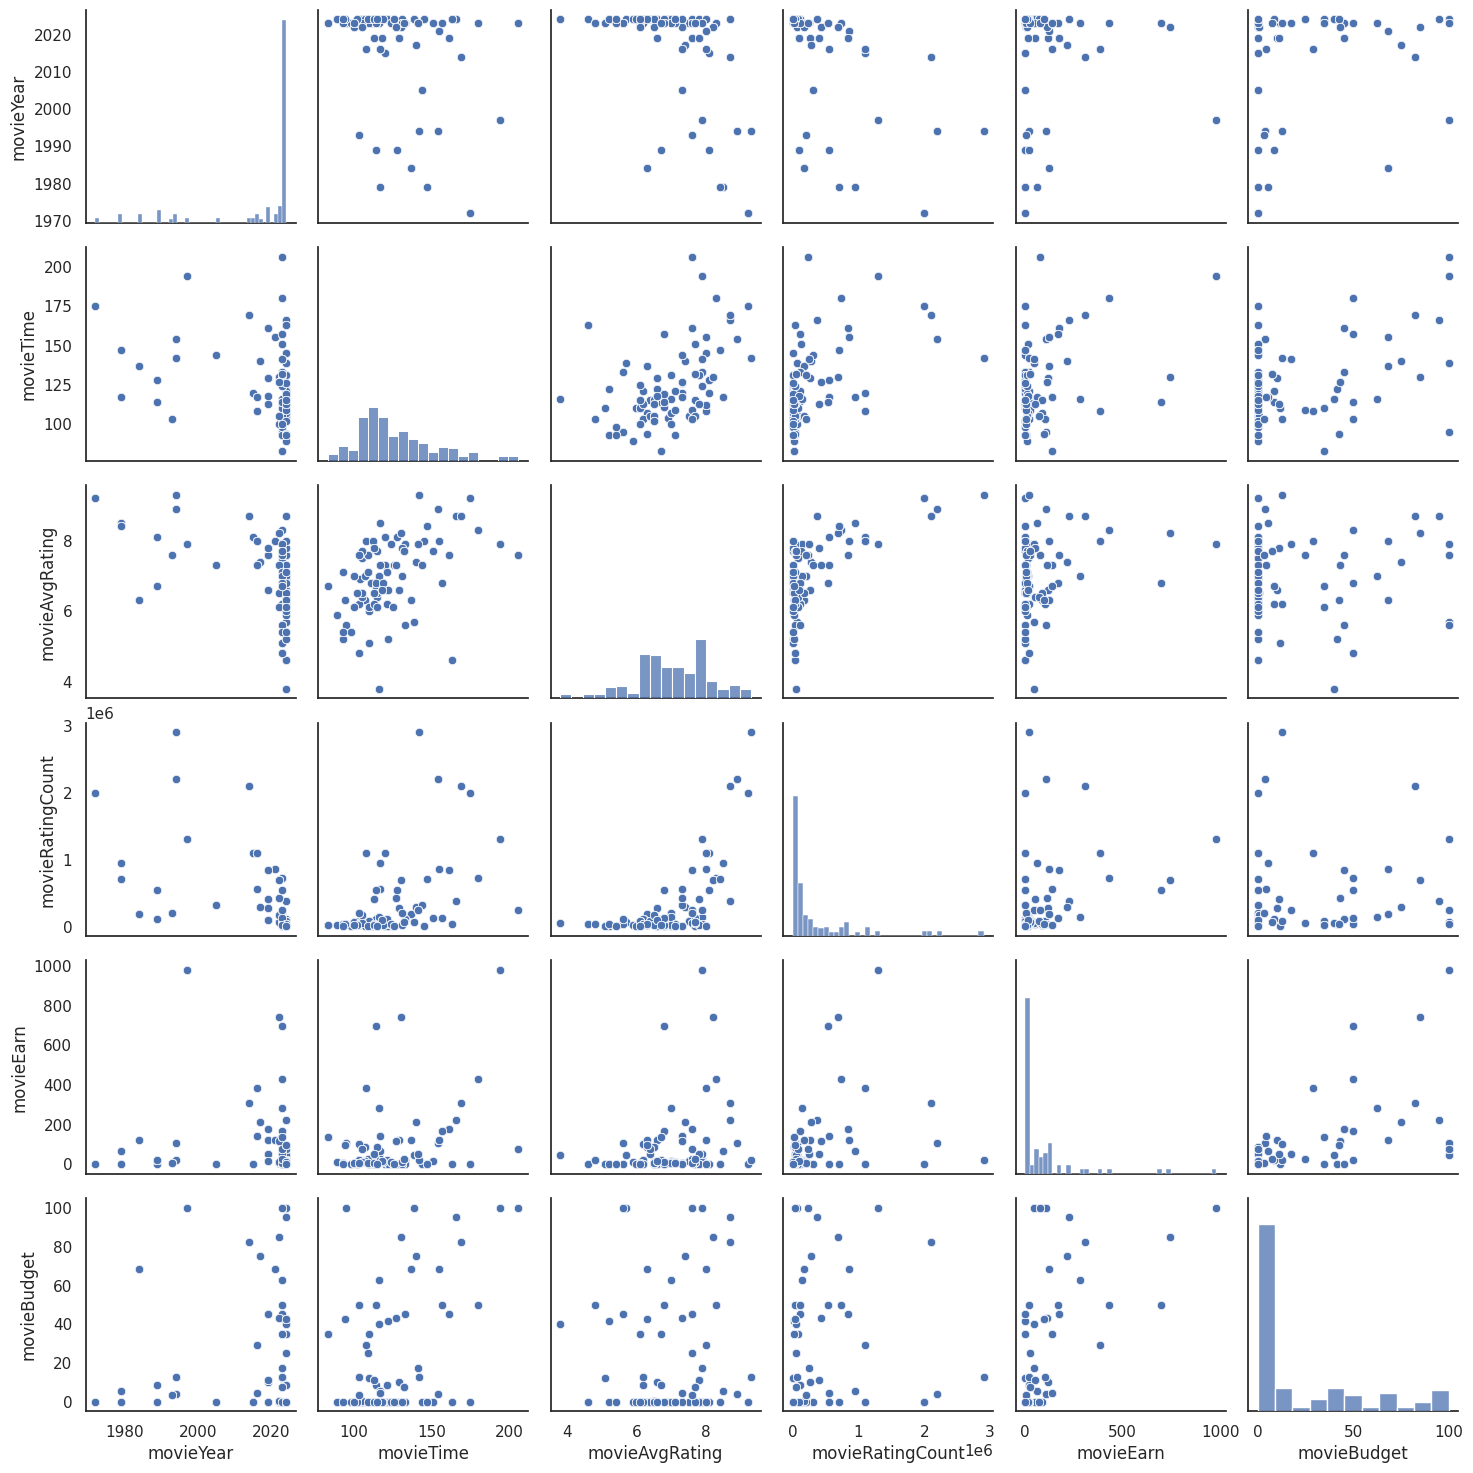

In [125]:
# Subset the DataFrame to include only numerical attributes
numerical_attributes = ['movieYear', 'movieTime', 'movieAvgRating', 'movieRatingCount', 'movieEarn', 'movieBudget']
numerical_df = visualization_df[numerical_attributes]

# Drop any rows with missing values
numerical_df.dropna(inplace=True)

# Create a pair plot
sns.pairplot(numerical_df)
plt.show()